In [15]:
from github import Github
import os
from collections import defaultdict, Counter
from statistics import *
from matplotlib import pyplot
import numpy as np
from matplotlib import dates as mdates

%matplotlib inline
pyplot.rcParams['figure.figsize'] = [20, 10]

In [2]:
g = Github(os.environ['GITHUB_ACCESS_TOKEN'])

# <strike>Lead time</strike> Time to resolve PRs

In [3]:
pui_repo = g.get_repo('ministryofjustice/laa-ccms-pui')

In [4]:
closed_prs = pui_repo.get_pulls(state='closed', sort='updated', direction='asc', base='master')

In [5]:
def hours_to_resolve(pr):
    """
    This is the number of hours the PR remained open. This includes time
    the PR was in a draft state
    """
    timedelta = (pr.closed_at or pr.merged_at) - pr.created_at
    return timedelta.total_seconds() / 3600


closed_date = [pr.closed_at or pr.merged_at for pr in closed_prs]
closed_pr_ttr = [hours_to_resolve(pr) for pr in closed_prs]

Text(0, 0.5, 'Age of pull request in hours')

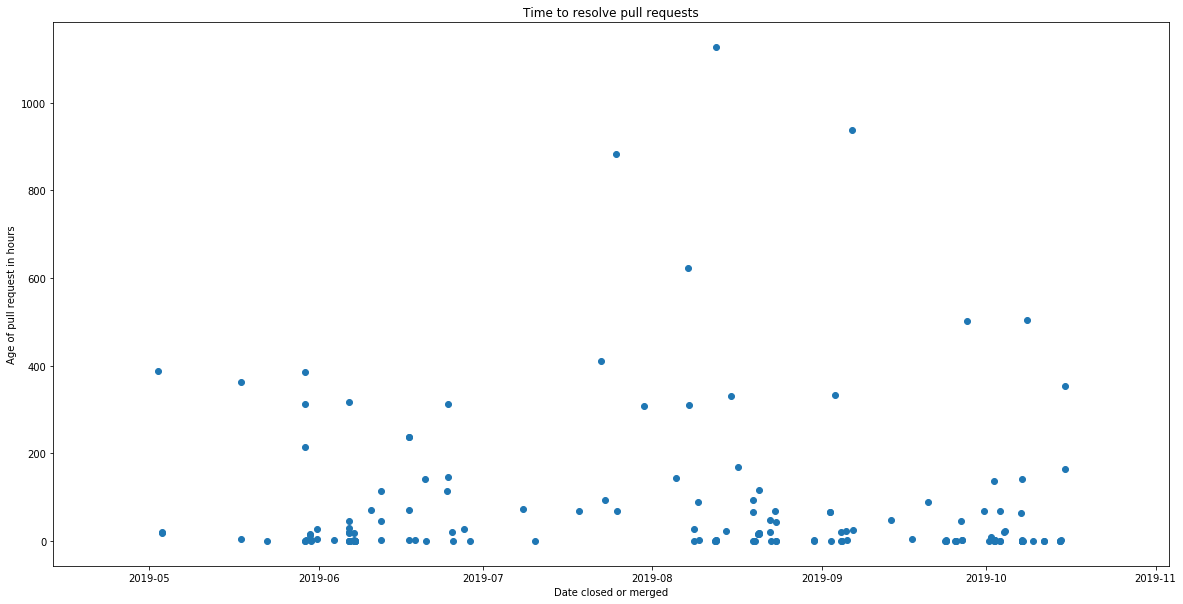

In [16]:
pyplot.scatter(closed_date, closed_pr_ttr)
pyplot.title('Time to resolve pull requests')
pyplot.xlabel('Date closed or merged')
pyplot.ylabel('Age of pull request in hours')

In [7]:
# Group PRs by the month they were merged/closed
closed_prs_by_month = defaultdict(list)
for pr in closed_prs:
    closed_at = pr.closed_at or pr.merged_at
    month = (closed_at.year, closed_at.month)
    closed_prs_by_month[month].append(pr)
    
time_to_resolve_by_month = {month: [hours_to_resolve(pr) for pr in prs] for month, prs in closed_prs_by_month.items()}
number_of_prs_by_month = {month: len(prs) for month, prs in closed_prs_by_month.items()}

In [8]:
mean_time_to_resolve_by_month = {month: mean(data) for month, data in time_to_resolve_by_month.items()}
mean_time_to_resolve_by_month

{(2019, 5): 93.77561403508771,
 (2019, 6): 54.30560810810811,
 (2019, 7): 238.4967013888889,
 (2019, 8): 94.4446913580247,
 (2019, 9): 86.2164423076923,
 (2019, 10): 42.953023809523806}

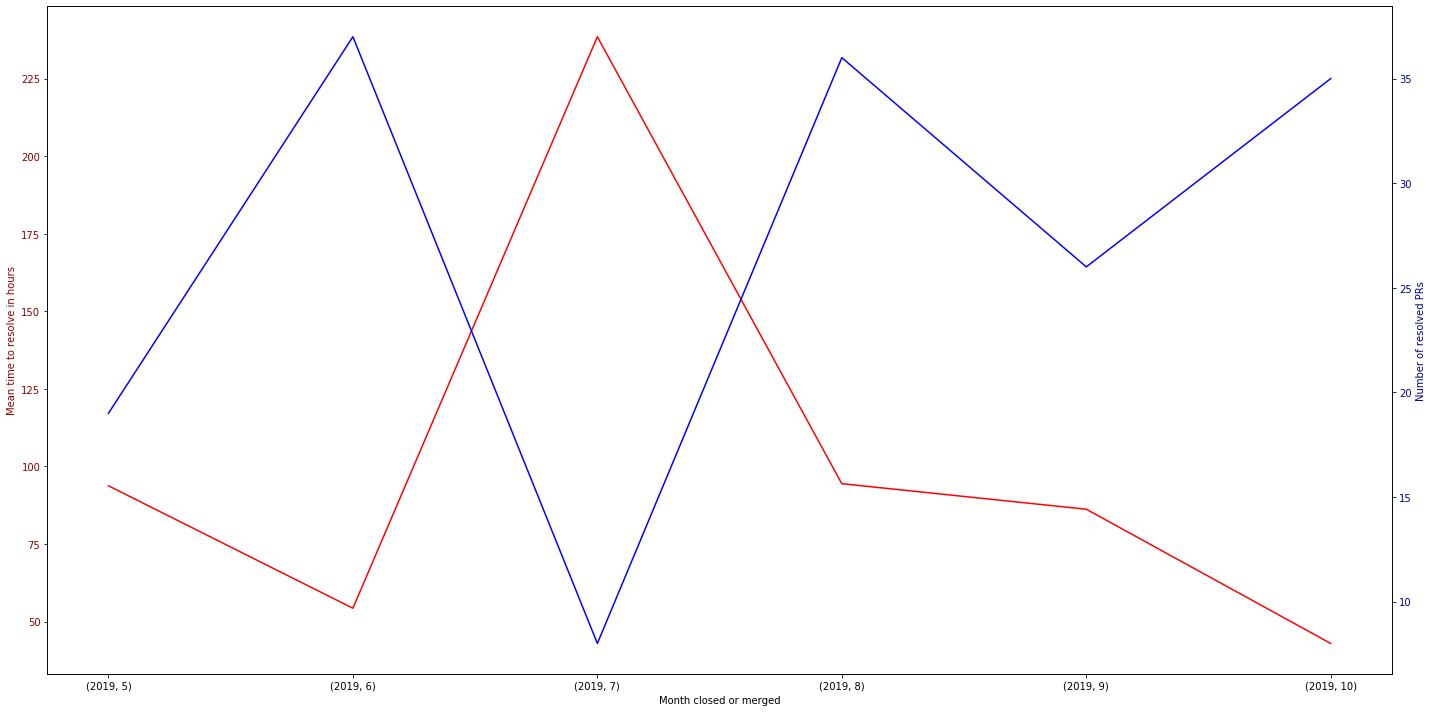

In [17]:
months = list(map(str, mean_time_to_resolve_by_month.keys()))
mean_ttr = list(mean_time_to_resolve_by_month.values())
number_of_prs = list(number_of_prs_by_month.values())

# Two scales per plot https://matplotlib.org/gallery/api/two_scales.html
fig, ax1 = pyplot.subplots()

color = 'darkred'
ax1.set_xlabel('Month closed or merged')
ax1.set_ylabel('Mean time to resolve in hours', color=color)
ax1.plot(months, mean_ttr, color='red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'darkblue'
ax2.set_ylabel('Number of resolved PRs', color=color)
ax2.plot(months, number_of_prs, color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Deployment frequency
NB: these figures include releases that didn't make it to production, so this overestimates how frequently we deploy.

In [10]:
releases = pui_repo.get_releases()
release_dates = [release.created_at for release in releases]
release_tags = [release.tag_name for release in releases]

In [11]:
# Count releases per month
month_counter = Counter((date.year, date.month) for date in release_dates)

for month in range(1,13):
    year_month = (2019, month)
    print(f'{year_month}: {month_counter[year_month]}')

(2019, 1): 0
(2019, 2): 0
(2019, 3): 0
(2019, 4): 0
(2019, 5): 3
(2019, 6): 1
(2019, 7): 0
(2019, 8): 0
(2019, 9): 0
(2019, 10): 1
(2019, 11): 0
(2019, 12): 0


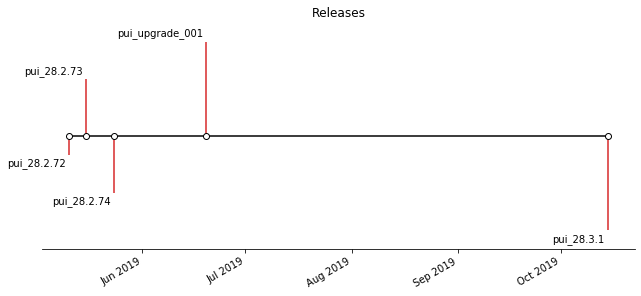

In [12]:
# Code from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/timeline.html

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(release_dates)/6)))[:len(release_dates)]

# Create figure and plot a stem plot with the date
fig, ax = pyplot.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Releases")

markerline, stemline, baseline = ax.stem(release_dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

pyplot.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(release_dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(release_dates, levels, release_tags, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
pyplot.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)

# Change failure
Measured as the percentage of PRs which are reverted.

This is an approximation: not all reverted commits were deployed to production, and not all failed changes need to be reverted.

In [13]:
revert_by_month = defaultdict(list)
ok_by_month = defaultdict(list)

for month, prs in closed_prs_by_month.items():
    for pr in prs:
        if pr.title.startswith('Revert'):
            revert_by_month[month].append(pr)
        else:
            ok_by_month[month].append(pr)

failure_rate_per_month = {}
for month in closed_prs_by_month.keys():
    reverted = len(revert_by_month[month])
    non_reverted = len(ok_by_month[month]) - reverted
    failure_rate = reverted / (reverted + non_reverted)
    failure_rate_per_month[month] = failure_rate
    
failure_rate_per_month

{(2019, 5): 0.0,
 (2019, 6): 0.027777777777777776,
 (2019, 7): 0.14285714285714285,
 (2019, 8): 0.0,
 (2019, 9): 0.0,
 (2019, 10): 0.06060606060606061}

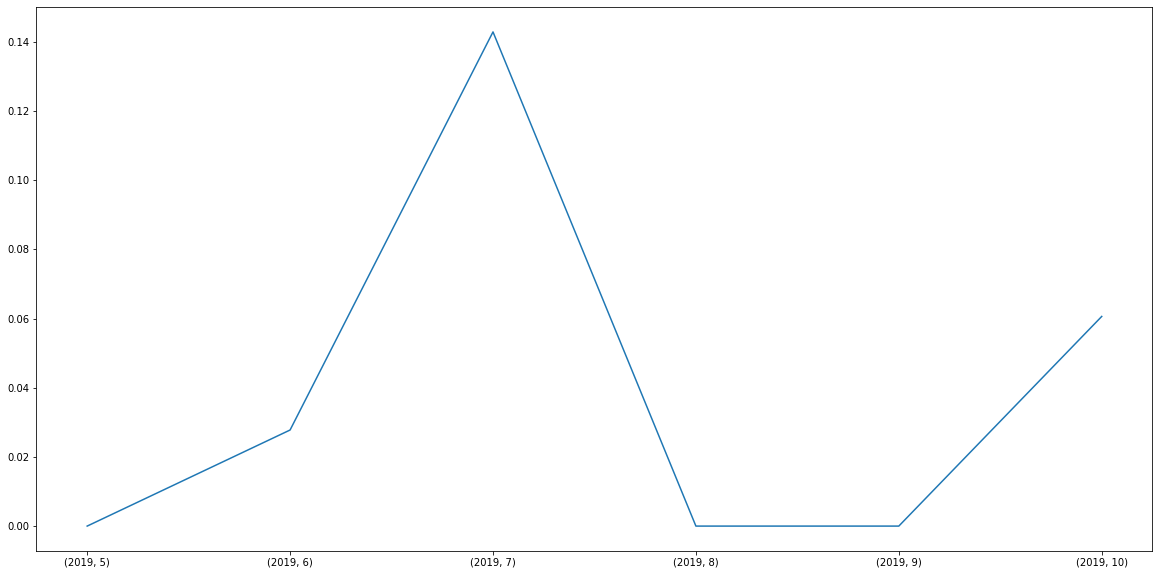

In [18]:
months = [str(month) for month in failure_rate_per_month.keys()]
failure_rates = list(failure_rate_per_month.values())
pyplot.plot(months, failure_rates)